In [2]:
import argparse
import os
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


/users/eleves-b/2021/laurine.meier/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    def forward(self, x):
     return self.act(self.bn(self.conv(x)))

In [7]:
class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))

In [8]:
class MLP(nn.Module):
      def __init__(self, image_channels=1, hidden_size=128, hidden_layers=5):
         super().__init__()
         self.initial_conv = ConvBlock(image_channels, hidden_size, kernel_size=7, stride=2, padding=3)
         self.conv_blocks = nn.Sequential(*[ConvBlock(hidden_size, hidden_size) for _ in range(hidden_layers - 1)])
         self.upsample = nn.ConvTranspose2d(hidden_size, hidden_size, kernel_size=4, stride=2, padding=1)  
         self.final_conv = nn.Conv2d(hidden_size, image_channels, kernel_size=3, stride=1, padding=1)
     
        
   
         layers = [nn.Linear(785, hidden_size), nn.GELU()]
         for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
         layers.append(nn.Linear(hidden_size, 28*28))
         self.joint_mlp = nn.Sequential(*layers)
    
      
    
      def forward(self, x,labels ):
        x.to(device)
        labels = labels.to(device)
        x = self.initial_conv(x)
        x = self.conv_blocks(x)
        x = self.upsample(x)  # Application de l'upsample\n",
        x = self.final_conv(x)

        x=x.view(x.size(0),-1)
        labels=labels.unsqueeze(1)
        x.to(device)
        x=torch.cat((x,labels),dim=-1)
        x=self.joint_mlp(x)
        
        
        return x

In [86]:
def train_bis(model, dataloader, optimizer, device, config):
    model.train()
    noise_factor = 0.5
    total_loss = 0
    for batch_idx , (data, labels) in tqdm(enumerate(dataloader)):
        for noise_factor in np.arange(0.4, 4, 0.2):

            noise = torch.randn_like(data) * noise_factor 

            noisy_data = data + noise
            noisy_data = noisy_data.to(device)
            data = data.to(device)

            optimizer.zero_grad()
    
               # Le modèle essaie de débruiter l'image\n",
            output = model(noisy_data,labels)
            output = output.view(32,1,28,28)
            output.to(device)

         # Calculer la perte par rapport aux images originales non bruitées\n",
            loss = F.mse_loss(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
  
    return total_loss / len(dataloader)

In [85]:
def train_bis_bis(model, dataloader, optimizer, device, config):
    model.train()
    noise_factor = 0.5
    total_loss = 0
    for batch_idx , (data, labels) in tqdm(enumerate(dataloader)):
        noisy_data_pred=data

        noise = torch.randn_like(data) * 0.5
        noisy_data_pred=noisy-data

        noisy_data = noisy_data_pred + noise
        noisy_data = noisy_data.to(device)
        data = data.to(device)

        optimizer.zero_grad()
    
               # Le modèle essaie de débruiter l'image\n",
        output = model(noisy_data,labels)
        output = output.view(32,1,28,28)
        output.to(device)

         # Calculer la perte par rapport aux images originales non bruitées\n",
        loss = F.mse_loss(output, noisy_data_pred)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
  
    return total_loss / len(dataloader)

In [45]:
def train_param(model, dataloader, optimizer, device, config):
    model.train()
    noise_factor = 0.5
    total_loss = 0
    for batch_idx , (data, labels) in tqdm(enumerate(dataloader)):
        for noise_factor in np.arange(0.1,1,0.1):
            # noise_factor = lambda
            noise = torch.randn_like(data) * noise_factor
            noisy_data=(1-noise_factor)*data + noise

            noisy_data = noisy_data + noise
            noisy_data = noisy_data.to(device)
            data = data.to(device)

            optimizer.zero_grad()
            
               # Le modèle essaie de débruiter l'image\n",
            output = model(noisy_data,labels)
            output = output.view(32,1,28,28)
            output.to(device)
            
            
         # Calculer la perte par rapport aux images originales non bruitées\n",
            loss = F.mse_loss(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
  
    return total_loss / len(dataloader)

In [157]:
def main(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) ])

    dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

    model = MLP().to(device)
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    losses=[]
    for epoch in range(config.num_epochs):
        loss = train_param(model, dataloader, optimizer, device,config) # train à choisir \n",
        losses.append(loss)
        print(f"Epoch: {epoch+1}, Loss: {loss}")
        
     # Sauvegarder le modèle\n",
    if not os.path.exists('models'):
        os.makedirs('models')
        
    torch.save(model.state_dict(), f"models/mnist_model_param_25_5.pth")
 
    # Tracer la courbe de la perte
    plt.plot(range(1, config.num_epochs + 1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Évolution de la perte pendant l\'entraînement')
    plt.show()
    
    return model
   

In [140]:
class Config:
    train_batch_size = 32
    num_epochs = 25
    learning_rate = 1e-4
    num_timesteps = 50
    beta_schedule = "linear"
    eval_batch_size = 1000
    image_size =28

1875it [01:16, 24.51it/s]


Epoch: 1, Loss: 1.382523910788695


1875it [01:18, 23.98it/s]


Epoch: 2, Loss: 1.09175041539371


1875it [01:18, 23.90it/s]


Epoch: 3, Loss: 1.0208308127890031


1875it [01:18, 23.94it/s]


Epoch: 4, Loss: 0.993246698174874


1875it [01:18, 23.94it/s]


Epoch: 5, Loss: 0.9797804244498411


1875it [01:18, 23.94it/s]


Epoch: 6, Loss: 0.9708145578066508


1875it [01:18, 23.92it/s]


Epoch: 7, Loss: 0.964381922391057


1875it [01:18, 23.91it/s]


Epoch: 8, Loss: 0.9584582837104797


1875it [01:18, 23.93it/s]


Epoch: 9, Loss: 0.9546428742756446


1875it [01:18, 23.97it/s]


Epoch: 10, Loss: 0.950368517652154


1875it [01:18, 23.99it/s]


Epoch: 11, Loss: 0.9472237882514795


1875it [01:18, 23.99it/s]


Epoch: 12, Loss: 0.9437635172456503


1875it [01:18, 24.00it/s]


Epoch: 13, Loss: 0.941917400893569


1875it [01:18, 24.00it/s]


Epoch: 14, Loss: 0.9392281585146983


1875it [01:18, 24.01it/s]


Epoch: 15, Loss: 0.9370500916878383


1875it [01:18, 24.00it/s]


Epoch: 16, Loss: 0.9350462700684865


1875it [01:18, 24.00it/s]


Epoch: 17, Loss: 0.9338020462463299


1875it [01:18, 24.00it/s]


Epoch: 18, Loss: 0.9322318218588829


1875it [01:18, 24.01it/s]


Epoch: 19, Loss: 0.9296386039286851


1875it [01:18, 24.00it/s]


Epoch: 20, Loss: 0.929520303539435


1875it [01:18, 23.98it/s]


Epoch: 21, Loss: 0.9290156475355228


1875it [01:18, 23.97it/s]


Epoch: 22, Loss: 0.9269454542279243


1875it [01:18, 23.96it/s]


Epoch: 23, Loss: 0.9260432983805736


1875it [01:18, 23.96it/s]


Epoch: 24, Loss: 0.9252398842533429


1875it [01:18, 23.97it/s]


Epoch: 25, Loss: 0.924093269666036


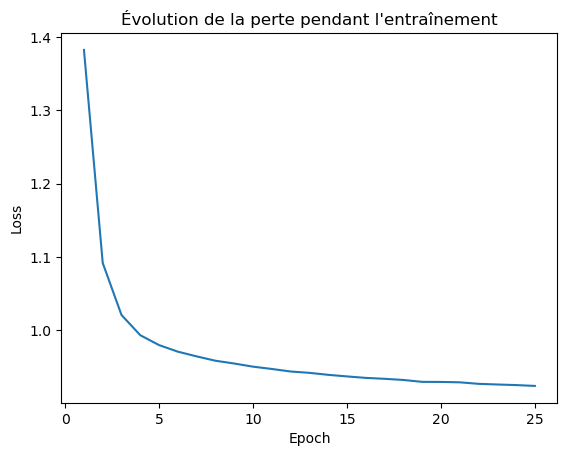

In [158]:
config = Config()
model = main(config)

In [11]:
def plot_digit(noisy_images,denoised_images,i):
    fig, axs = plt.subplots(2, 5, figsize=(15, 9))

    fig.suptitle(f"Nombre de fois où le modèle est appliqué : {i}")
    for i in range(5):
        axs[0, i].imshow(noisy_images[i].squeeze().detach().cpu().numpy(), cmap='gray')
        axs[0, i].title.set_text('Bruitée')
        axs[0, i].axis('off')

        axs[1, i].imshow(denoised_images[i].squeeze().detach().cpu().numpy(), cmap='gray')
        axs[1, i].title.set_text('Débruitée')
        axs[1, i].axis('off')

    plt.show()

12000
60000
MLP(
  (initial_conv): ConvBlock(
    (conv): Conv2d(1, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
  )
  (conv_blocks): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (1): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (2): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
    )
    (3): ConvBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), 

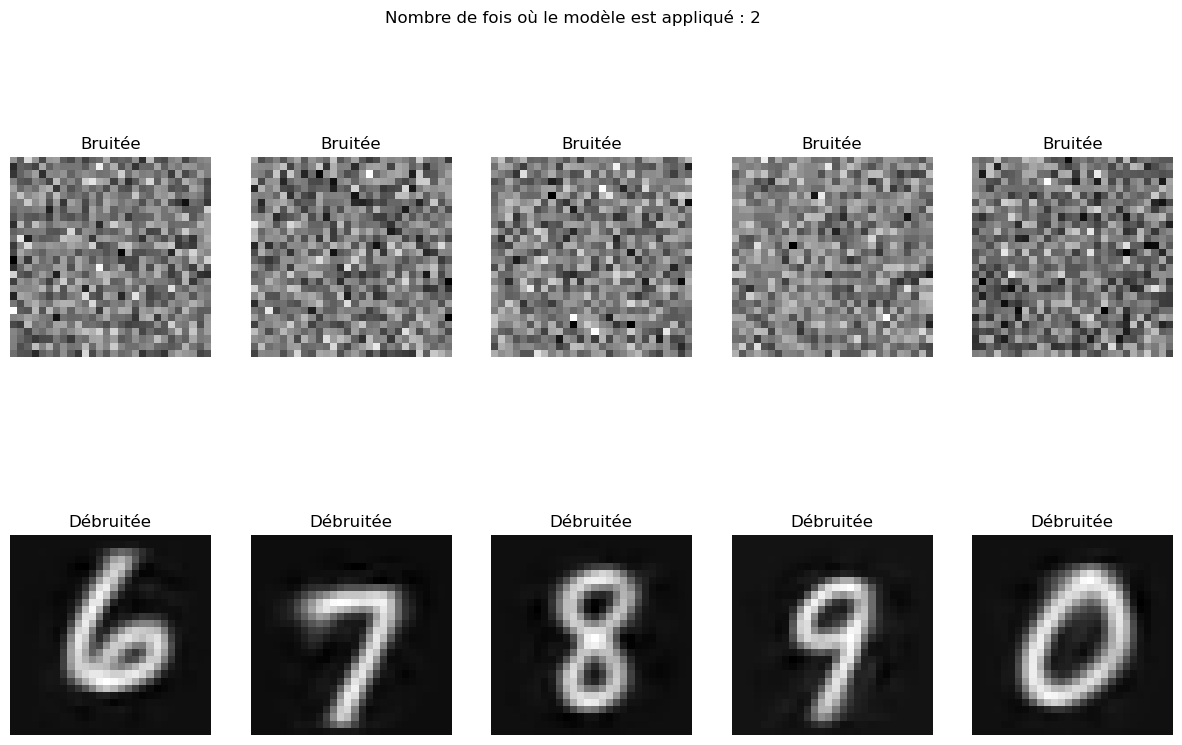

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_data, batch_size=5, shuffle=True)
print(len(mnist_loader))
print(len(mnist_data))

model = MLP()
model.to(device)
model.load_state_dict(torch.load("models/mnist_model_param_25_5.pth"))
model.eval()
# Afficher l'architecture du modèle
print(model)

# Prendre 5 images du dataset MNIST et les bruiter
images, _ = next(iter(mnist_loader))

labels = torch.tensor([6,7,8,9,0])
noisy_images =  torch.randn_like(images)
noisy_images = noisy_images.to(device)
labels=labels.to(device)

# for i in range(1, 10):  
denoised_images = noisy_images.clone().detach()  

for j in range(4):
    denoised_images = model(denoised_images, labels)
    denoised_images = denoised_images.view(5, 1, 28, 28)

    
plot_digit(noisy_images, denoised_images, 2)

    